In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
from nltk import FreqDist
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
import gensim.downloader as api
from sklearn.decomposition import PCA
import seaborn as sns

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
#load data
df = pd.read_csv("NikeProductDescriptions.csv")

#show basic information like the nb of nulls an type of data
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Title                400 non-null    object
 1   Subtitle             400 non-null    object
 2   Product Description  400 non-null    object
dtypes: object(3)
memory usage: 9.5+ KB
None


In [3]:
print(df.describe(include="all"))

                  Title       Subtitle  \
count               400            400   
unique              254            228   
top     Nike Sportswear  Women's Shoes   
freq                 41             34   

                                      Product Description  
count                                                 400  
unique                                                400  
top     It doesn't get more legendary than this. Desig...  
freq                                                    1  


In [4]:
print(df.head())

                          Title     Subtitle  \
0          Nike Air Force 1 '07  Men's Shoes   
1          Nike Air Max Dawn SE  Men's Shoes   
2  Nike SB Dunk Low Pro Premium  Skate Shoes   
3   Nike Air Force 1 Mid '07 LX  Men's Shoes   
4      Nike Air Force 1 Mid '07  Men's Shoes   

                                 Product Description  
0  It doesn't get more legendary than this. Desig...  
1  Find out what moves you with the Air Max Dawn....  
2  Pack your style—on your feet. Bringing a fresh...  
3  The celebrations just keep coming. Unbox the A...  
4  Got your fave colour yet? No worries, the Colo...  


In [5]:
#number of unique Subtitles before filtring and normalizing Shorts
print(len(df['Subtitle'].unique()))

228


In [6]:
#filter subtitles keep only the target subtitles
target_subtitles = ["Men's Shoes", "Men's T-Shirt", "Women's Shoes", "Skate Shoes", "Older Kids' T-Shirt"]
df_filtered = df[df['Subtitle'].isin(target_subtitles) | df['Subtitle'].str.contains("Shorts", case=False)].copy()

In [7]:
#replace subtitles that contain "Shorts" by term "Short"
df_filtered['Subtitle'] = df_filtered['Subtitle'].apply(lambda x: "Shorts" if "Shorts" in x else x)

In [8]:
#the number of unique subtitles after filtrering
print(len(df_filtered['Subtitle'].unique()))

6


In [9]:
#simple clean function to remove stopwords and tokenize the text
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    return tokens

In [10]:
#apply tokenization in the product description
df_filtered['tokens'] = df_filtered['Product Description'].apply(clean_text)

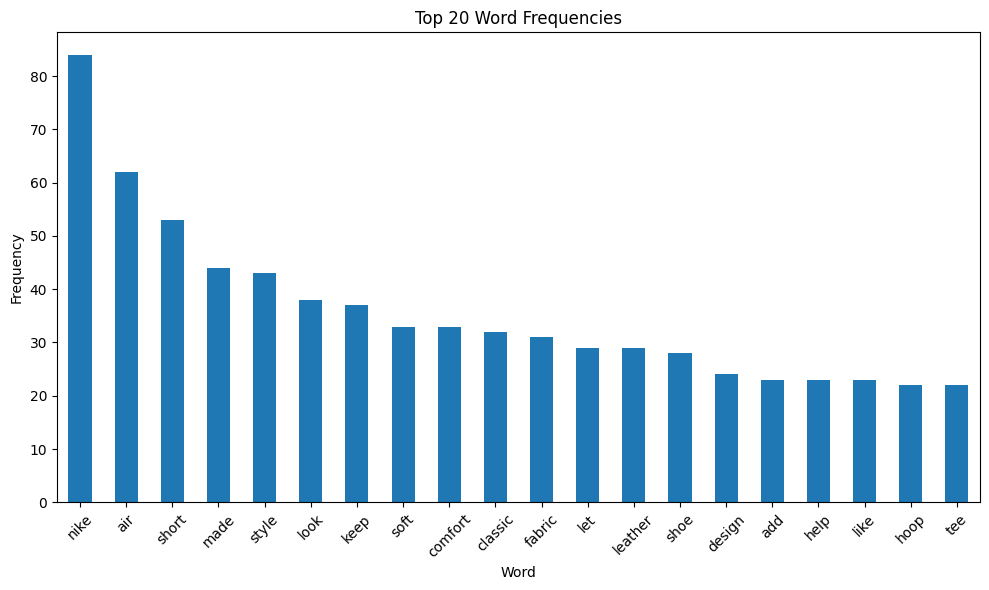

In [11]:
#group the list of token lists into a single list to use it in next steps
all_words = [word for tokens in df_filtered['tokens'] for word in tokens]

df_words = pd.DataFrame(all_words, columns=["word"])

#count top 20 most frequent words
top_words = df_words['word'].value_counts().head(20)

#plot the words and their frequency in a bar chart
plt.figure(figsize=(10,6))
top_words.plot(kind='bar')
plt.title("Top 20 Word Frequencies")
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


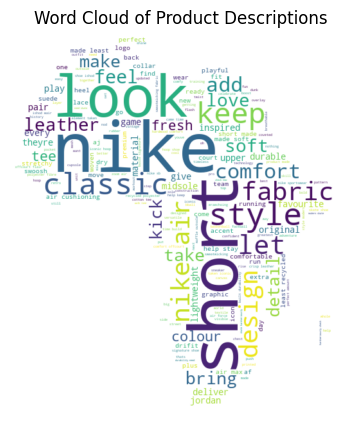

In [12]:
#load the image to set it in the background of the WordCloud chart
response = requests.get("https://www.shutterstock.com/image-vector/africa-map-icon-on-white-600nw-1913568712.jpg")
img = np.array(Image.open(BytesIO(response.content)))
# Replace 0 value to 255 (the mask argument of Wordcloud require white pixels to be 255 instead of 0)
img[img == 0] = 255
# Create a word cloud
wordcloud = WordCloud(width=800, height=400, mask=img, background_color='white').generate(" ".join(all_words))

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Product Descriptions")
plt.show()

In [13]:
#extract the list of product descriptions from the filtered df for further text processing
docs = df_filtered['Product Description'].tolist()

### 1. BOW
Creation of a Bag-of-Words (BOW) representation of the product descriptions. We will convert each product description into a vector counting the occurrences of each word.

In [14]:
bow_vectorizer = CountVectorizer()
X_bow = bow_vectorizer.fit_transform(docs)

### 2. TF-IDF
Creation of TF-IDF representation of the product descriptions. The role of TF-IDF is to give a weighted score for each word based on its frequency in a document and rarity across all documents

In [15]:
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(docs)

### 3. Word2Vec

Creation of Word2Vec representation of the product descriptions. Its role is to learn vector representations for words based on their context in the corpus, capturing semantic relationships. Each product description is then represented by the average of its word vectors to form a dense, continuous embedding.

In [16]:
#train a Word2Vec model on the tokenized product descriptions
model_w2v = Word2Vec(sentences=df_filtered['tokens'], vector_size=100, window=5, min_count=1)

In [17]:
#function to compute the average word vector for a product description
def average_vector(tokens, model):
    vectors = [model.wv[w] for w in tokens if w in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)


In [18]:
#generate document-level embeddings by averaging word vectors for each product description
X_w2v = np.array([average_vector(toks, model_w2v) for toks in df_filtered['tokens']])

### 4. Golve
Creation of GloVe representation of  product descriptions using pre-trained word vectors based on global word co-occurrence, capturing semantic meaning through the average of each word's embedding.

In [19]:
# load the Golve model
glove_model = api.load("glove-wiki-gigaword-100")

In [20]:
#generate document embeddings using the GloVe model by computing the average vector of all word embeddings
X_glove = np.array([
    np.mean([glove_model[w] for w in tokens if w in glove_model] or [np.zeros(100)], axis=0)
    for tokens in df_filtered['tokens']
])

### 5. PCA Plot

In [21]:
#simple function to perform PCA on the input data and visualize the first two principal components
#to avoid repeating same thing for all methods

def pca_plotting(data, plot_title):
    pca = PCA(n_components=2)
    transformed_data = pca.fit_transform(data)
    plot_data = pd.DataFrame(transformed_data, columns=['PC1', 'PC2'])
    plot_data['Subtitle'] = df_filtered['Subtitle'].values
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=plot_data, x='PC1', y='PC2', hue='Subtitle', palette='Set2')
    plt.title(f"PCA of Product Descriptions - {plot_title}")
    plt.show()


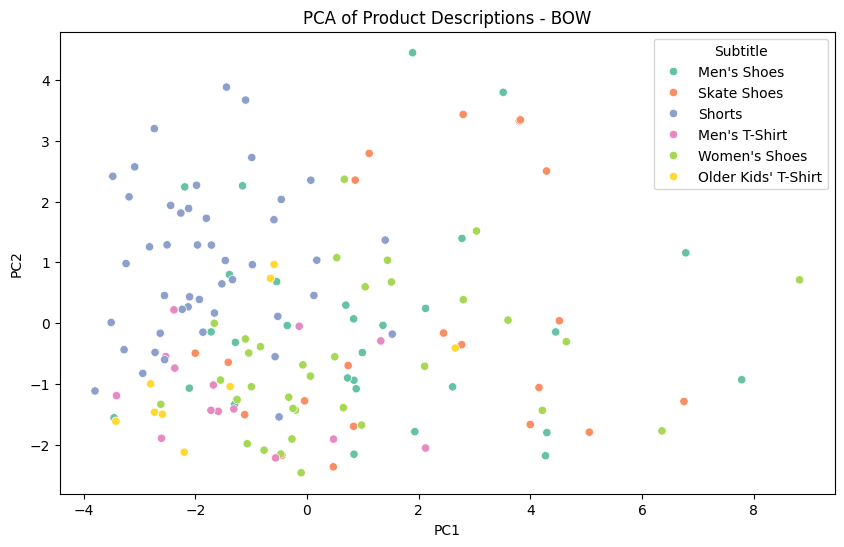

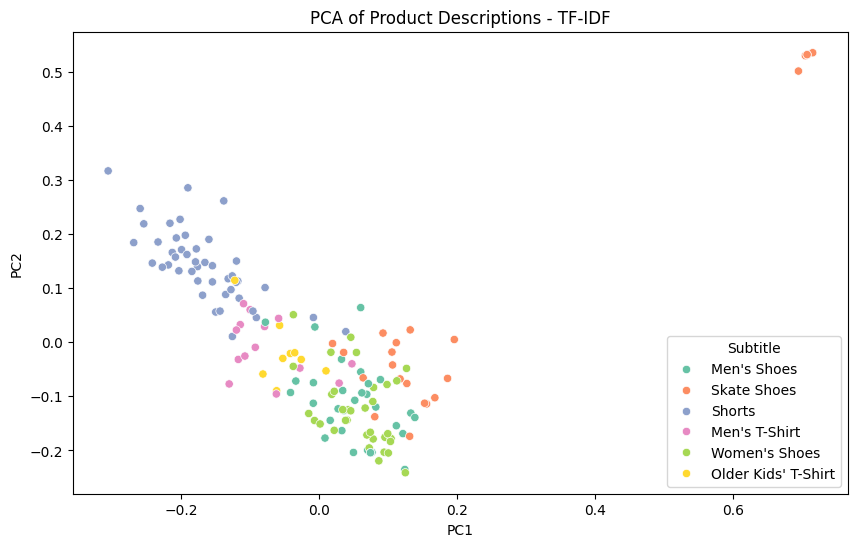

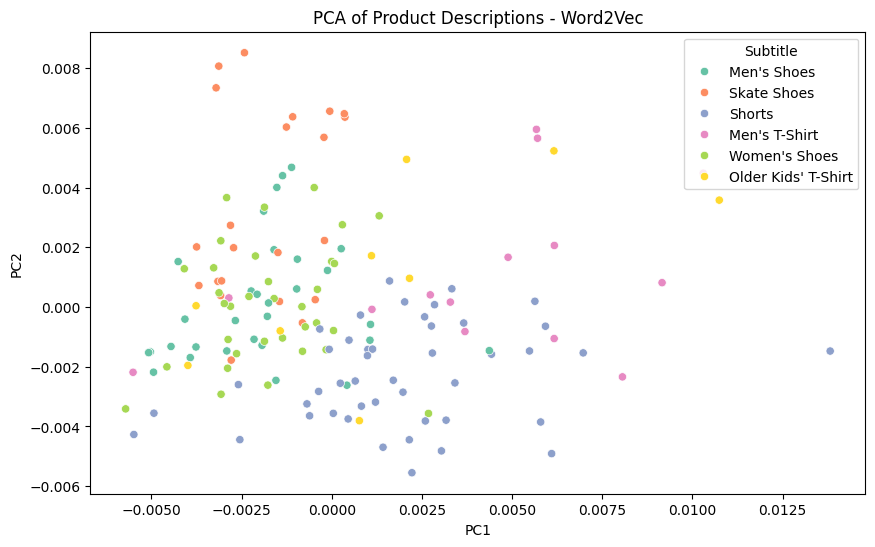

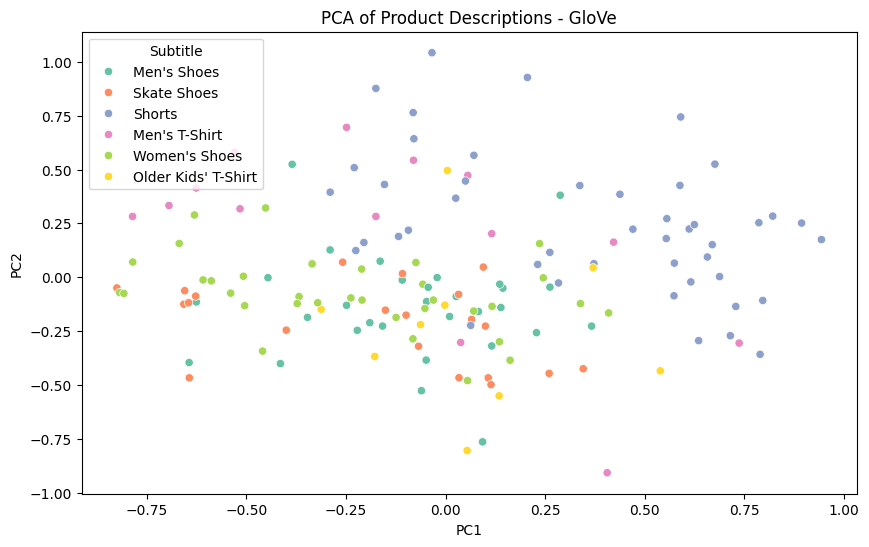

In [22]:
#call for each method
pca_plotting(X_bow.toarray(), "BOW")
pca_plotting(X_tfidf.toarray(), "TF-IDF")
pca_plotting(X_w2v, "Word2Vec")
pca_plotting(X_glove, "GloVe")


### 6. conclusion based on PCA: 

- **Bag of Words**: Words are treated in isolation, so the product categories blend together without clear groupings.

- **TF-IDF**: Gives the best category separation by highlighting important, distinctive words—great for classification.

- **Word2Vec**: Captures word meaning well, but averaging weakens category separation—better for finding similarities.

- **GloVe**: Adds semantic depth and shows some grouping, especially for certain categories, but still overlaps due to averaging.

- In conclusion I can see that : **TF-IDF** is the best method for clustering and distinguishing categories in this use case. It is particularly effective for classification or clustering based on product descriptions. However, if the goal shifts towards semantic similarity or recommendations, **Word2Vec** or **GloVe** may still be the better choice, as they better capture the semantic meaning of words.